In [5]:
#clustering on the "Wholesale customers data" dataset.
##Steps:
#1. Load data
#2. Exploratory Data Analysis
##3. Preprocessing & Scaling
#4. KMeans (elbow + silhouette)
#5. Agglomerative (hierarchical)
#6. DBSCAN (with k-distance plot to choose eps)
#7. PCA for visualization


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

sns.set(style="whitegrid")
RANDOM_STATE = 42

In [7]:
df = pd.read_csv("/content/Wholesale customers data.csv")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


Shape: (440, 8)


,count,mean,std,min,25%,50%,75%,max
Channel,440.0,1.322727,0.468052,1.0,1.00,1.0,2.00,2.0
Region,440.0,2.543182,0.774272,1.0,2.00,3.0,3.00,3.0
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0



Missing values:
 Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


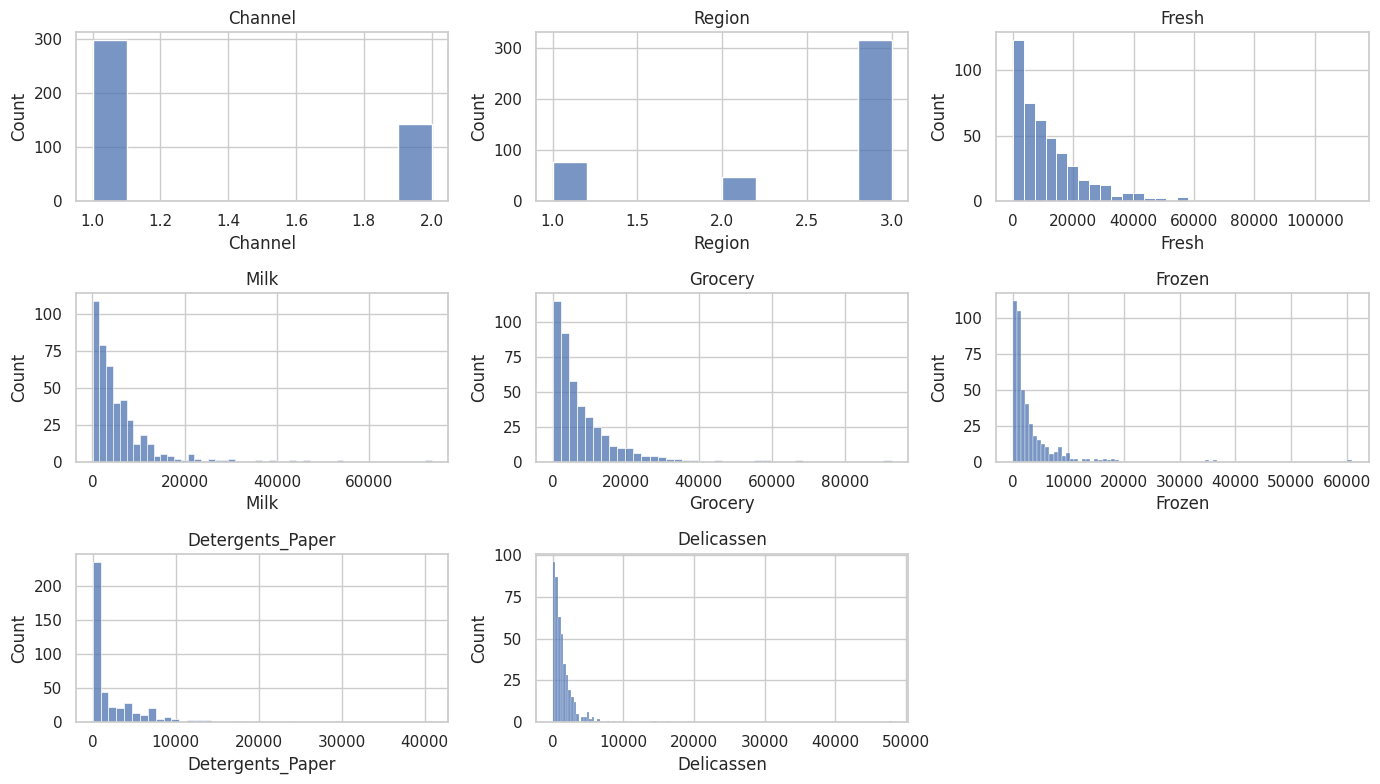

In [8]:
# Basic info
print("Shape:", df.shape)
display(df.describe().T)

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Distribution histograms for numeric features
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(14, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=False)
    plt.title(col)
plt.tight_layout()

In [9]:
# For clustering we will drop 'Channel' and 'Region' (categorical-like) and use only numeric spending columns.

X = df.drop(columns=['Channel', 'Region'], errors='ignore')  # errors='ignore' to be safe
feature_names = X.columns.tolist()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features used for clustering:", feature_names)
print("Scaled shape:", X_scaled.shape)

Features used for clustering: ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
Scaled shape: (440, 6)


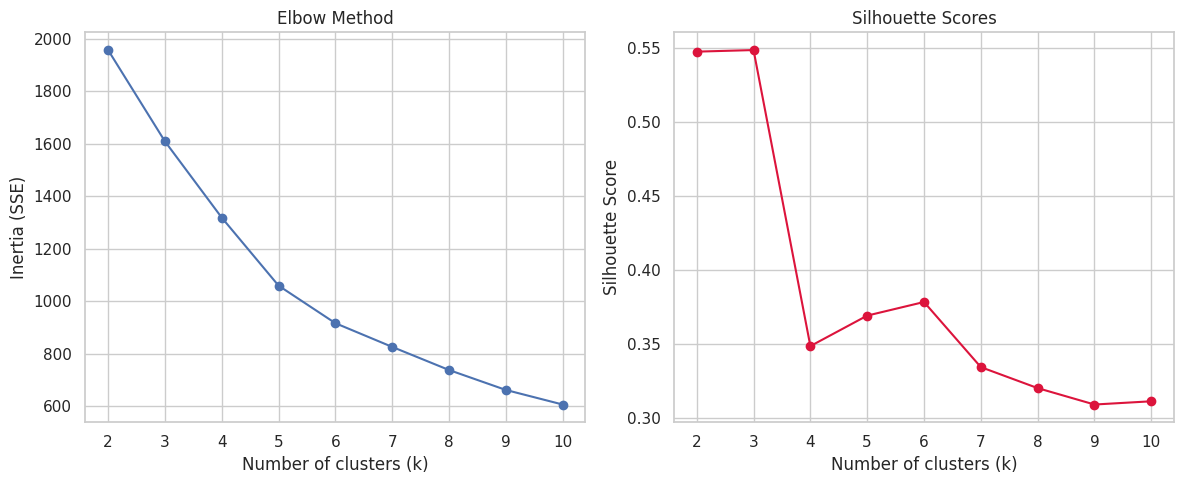

k	Inertia		Silhouette
2	1956.12	0.5472
3	1608.43	0.5483
4	1317.84	0.3485
5	1058.77	0.3690
6	915.74	0.3782
7	825.40	0.3343
8	737.39	0.3201
9	661.45	0.3090
10	605.92	0.3112


In [11]:
inert = []
s_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inert.append(kmeans.inertia_)
    s_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, inert, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(K, s_scores, marker='o', color='crimson')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')

plt.tight_layout()
plt.show()

# Print values
print("k\tInertia\t\tSilhouette")
for k, ii, ss in zip(K, inert, s_scores):
    print(f"{k}\t{ii:.2f}\t{ss:.4f}")

In [12]:
#Fit KMeans with chosen k
km_opt = 3

kmeans = KMeans(n_clusters=km_opt, random_state=RANDOM_STATE, n_init=20)
kmeans_labels = kmeans.fit_predict(X_scaled)
df['KMeans_cluster'] = kmeans_labels

print("KMeans silhouette:", silhouette_score(X_scaled, kmeans_labels))
df['KMeans_cluster'].value_counts().sort_index()

KMeans silhouette: 0.5482872649700601


,count
KMeans_cluster,
0,45
1,393
2,2


In [13]:
#Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=km_opt, linkage='ward')
agg_labels = agg.fit_predict(X_scaled)
df['Agg_cluster'] = agg_labels
print("Agglomerative silhouette:", silhouette_score(X_scaled, agg_labels))
df['Agg_cluster'].value_counts().sort_index()

Agglomerative silhouette: 0.2646091480214908


,count
Agg_cluster,
0,6
1,281
2,153


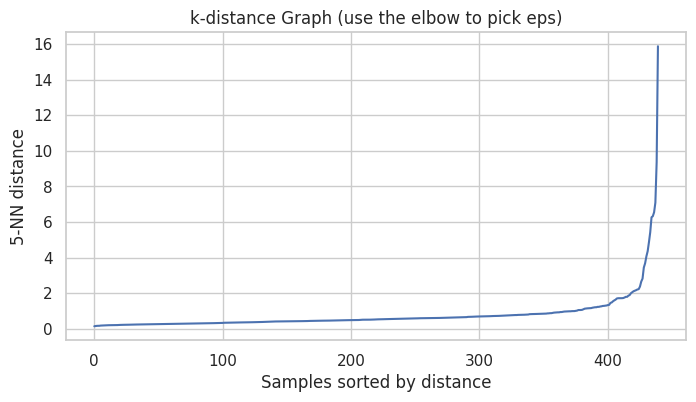

In [16]:
#DBSCAN
m_samples = 5
neighbors = NearestNeighbors(n_neighbors=m_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
# k-distance = distances sorted by distance to k-th neighbor
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(8,4))
plt.plot(k_distances)
plt.ylabel(f"{m_samples}-NN distance")
plt.xlabel("Samples sorted by distance")
plt.title("k-distance Graph (use the elbow to pick eps)")
plt.grid(True)
plt.show()


In [18]:
#Fit DBSCAN
# Replace eps value with the one you pick after looking at the k-distance plot
e_value = 2.0
dbscan = DBSCAN(eps=e_value, min_samples=m_samples)
db_labels = dbscan.fit_predict(X_scaled)
df['DBSCAN_cluster'] = db_labels


print("Unique DBSCAN labels:", np.unique(db_labels))
n_noise = np.sum(db_labels == -1)
print("Noise points:", n_noise, "out of", len(db_labels))


unique_labels = set(db_labels) - {-1}
if len(unique_labels) >= 2:
    print("DBSCAN silhouette:", silhouette_score(X_scaled[db_labels != -1], db_labels[db_labels != -1]))
else:
    print("DBSCAN silhouette: Not applicable (too few clusters)")


Unique DBSCAN labels: [-1  0]
Noise points: 13 out of 440
DBSCAN silhouette: Not applicable (too few clusters)


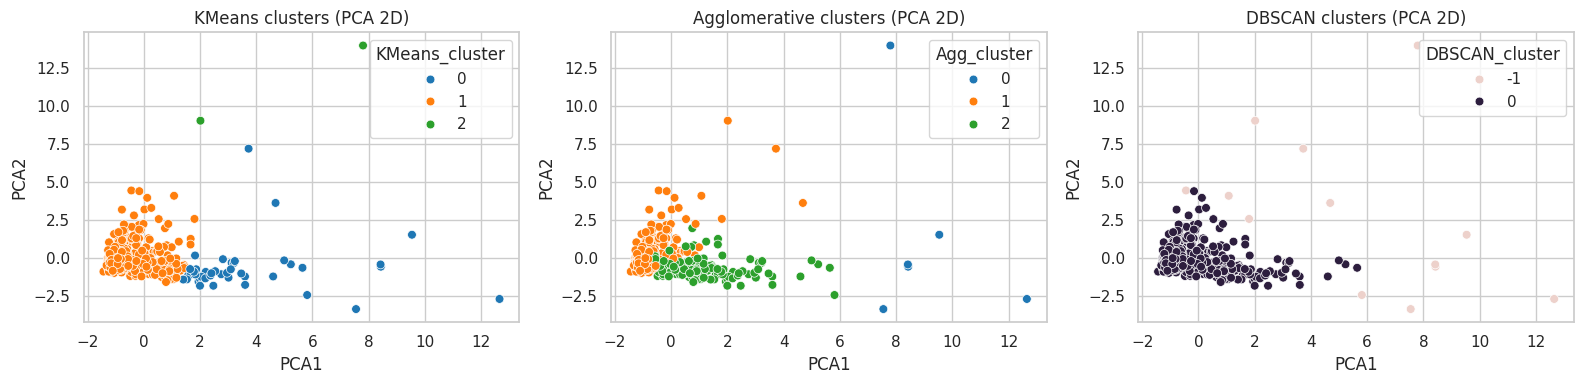

In [19]:
#PCA visualization (2D)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:,0]
df['PCA2'] = X_pca[:,1]

plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans_cluster', palette='tab10', data=df, s=40)
plt.title('KMeans clusters (PCA 2D)')

plt.subplot(1,3,2)
sns.scatterplot(x='PCA1', y='PCA2', hue='Agg_cluster', palette='tab10', data=df, s=40)
plt.title('Agglomerative clusters (PCA 2D)')

plt.subplot(1,3,3)
# For DBSCAN show noise specially
palette = sns.color_palette('tab10', np.unique(df['DBSCAN_cluster']).shape[0])
sns.scatterplot(x='PCA1', y='PCA2', hue='DBSCAN_cluster', data=df, s=40, legend='full')
plt.title('DBSCAN clusters (PCA 2D)')

plt.tight_layout()
plt.show()


In [20]:
#cluster interpretation
# Group means by cluster for insight (KMeans example)
kmeans_summary = df.groupby('KMeans_cluster')[feature_names].mean().T
display(kmeans_summary)

# You can do similar for Agglomerative / DBSCAN:
agg_summary = df.groupby('Agg_cluster')[feature_names].mean().T
display(agg_summary)


KMeans_cluster,0,1,2
Fresh,10440.933333,12062.913486,34782.0
Milk,19386.422222,4115.099237,30367.0
Grocery,28656.088889,5534.966921,16898.0
Frozen,2190.244444,2940.676845,48701.5
Detergents_Paper,13327.800000,1696.170483,755.5
Delicassen,2374.200000,1299.114504,26776.0


Agg_cluster,0,1,2
Fresh,27477.000000,15048.932384,5794.241830
Milk,43542.166667,3017.298932,9419.888889
Grocery,54588.500000,3791.761566,13761.738562
Frozen,8285.666667,3837.316726,1461.764706
Detergents_Paper,25018.333333,758.007117,5913.379085
Delicassen,10247.833333,1309.900356,1577.607843
